In this tutorial, we will perform spatial deconvolution and spatial clustering using 10X Visium human dorsolaterl prefrontal cortex (DLPFC) dataset. For this tutorial slide 151673 was choosen. The spatial data have gold standard manual annotations of seven cortical layer (layer-1 to layer-6 and white matter).scRNA-seq reference obtained from GEO (accession id: GSE144136).
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hfn10gV3NbG4guAgOb1DRkSam4RxfdI1?usp=sharing)

## Install libraries

In [ ]:
!pip install scanpy
!pip install spatialprompt
!pip install gdown

## Import necessary libraries

In [2]:
import pandas as pd
import scanpy as sc
import spatialprompt as sp
import numpy as np
import urllib

## Data Download
### Here the original scRNA-seq data have 78,886 cells and 30,062 genes. Due to limited ram offered by colab the reference data was trimmed to 10,000 cells and 5,000 high variance genes.
### Due to trim down the reference, result in the manuscript and the result we see here may vary slightly.
### If the user have to trim down the reference, don't trim the cell type have less counts.

In [3]:
!gdown https://drive.google.com/uc?id=1RcC0lu_rmVxcElRFWuTPbm12z94IwLQx
!gdown https://drive.google.com/uc?id=1jG9s91hTf1JeFheHHzsNN6Mk13qOjt6e
!gunzip libd_sc_obj.gz
!gunzip libd_st_obj.gz

Downloading...
From: https://drive.google.com/uc?id=1RcC0lu_rmVxcElRFWuTPbm12z94IwLQx
To: /content/libd_sc_obj.gz
100% 16.0M/16.0M [00:00<00:00, 34.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jG9s91hTf1JeFheHHzsNN6Mk13qOjt6e
To: /content/libd_st_obj.gz
100% 28.0M/28.0M [00:01<00:00, 21.5MB/s]


## Read the data

In [4]:
sc_data = sc.read_h5ad("libd_sc_obj")
st_data = sc.read_h5ad("libd_st_obj")

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
st_data

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'layer_colors', 'spatial'
    obsm: 'spatial'

## Plot the data

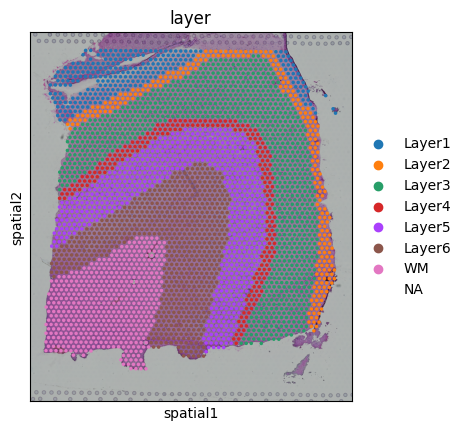

In [6]:
sc.pl.spatial(st_data,color="layer")

In [7]:
sc_df = sc_data.X
sc_genes = sc_data.var_names
sc_labels = sc_data.obs.loc[:,"labels"]
st_df = st_data.X.toarray()
st_genes = st_data.var_names
st_X = st_data.obs.array_row
st_Y = st_data.obs.array_col

## Spatial Deconvolution

In [8]:
deconvolution_model = sp.SpatialDeconvolution()

Here, spot_ratio was choosen as [0,0,1] as the cell-types comprised of multiple sub-celltypes. So for simulation, we will simulate spots by randomly aggregating cells. Other parameters put as it is.

In [45]:
cortex_predict = deconvolution_model.predict_cell_prop(sc_array = sc_df,
                                                       st_array = st_df,
                                                       sc_genes = sc_genes,
                                                      st_genes = st_genes,
                                                       sc_labels = sc_labels,
                                                       x_cord = st_X,
                                                       y_cord = st_Y,
                                                       spot_ratio= [0,0,1])

Preprocessing Datasets : |████████████████████████████████████████| 6/6 [100%] in 2.0s (3.03/s) 
4682 Common Genes Found 1000 HVGs Retained
Simulate Spatial Spots : |████████████████████████████████████████| 25586/25586 [100%] in 13.7s (1871.05/s) 
25586 Spatial Spots Simulated
Capturing spatial microenvironment relation: |████████████████████████████████████████| 5/5 [100%] in 6.5s (0.77/s) 
Spot Denvolution: |████████████████████████████████████████| 5/5 [100%] in 11.2s (0.45/s) 
Total Time spent: 33.45342397689819 Sec


In [46]:
#Insert the cell type proportions into the spatial object
for i in cortex_predict.columns:
    st_data.obs.loc[:,i] = np.array(cortex_predict.loc[:,i])

In [47]:
st_data

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'layer', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6', 'SpatialPrompt: clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'layer_colors', 'spatial', 'SpatialPrompt: clusters_colors'
    obsm: 'spatial'

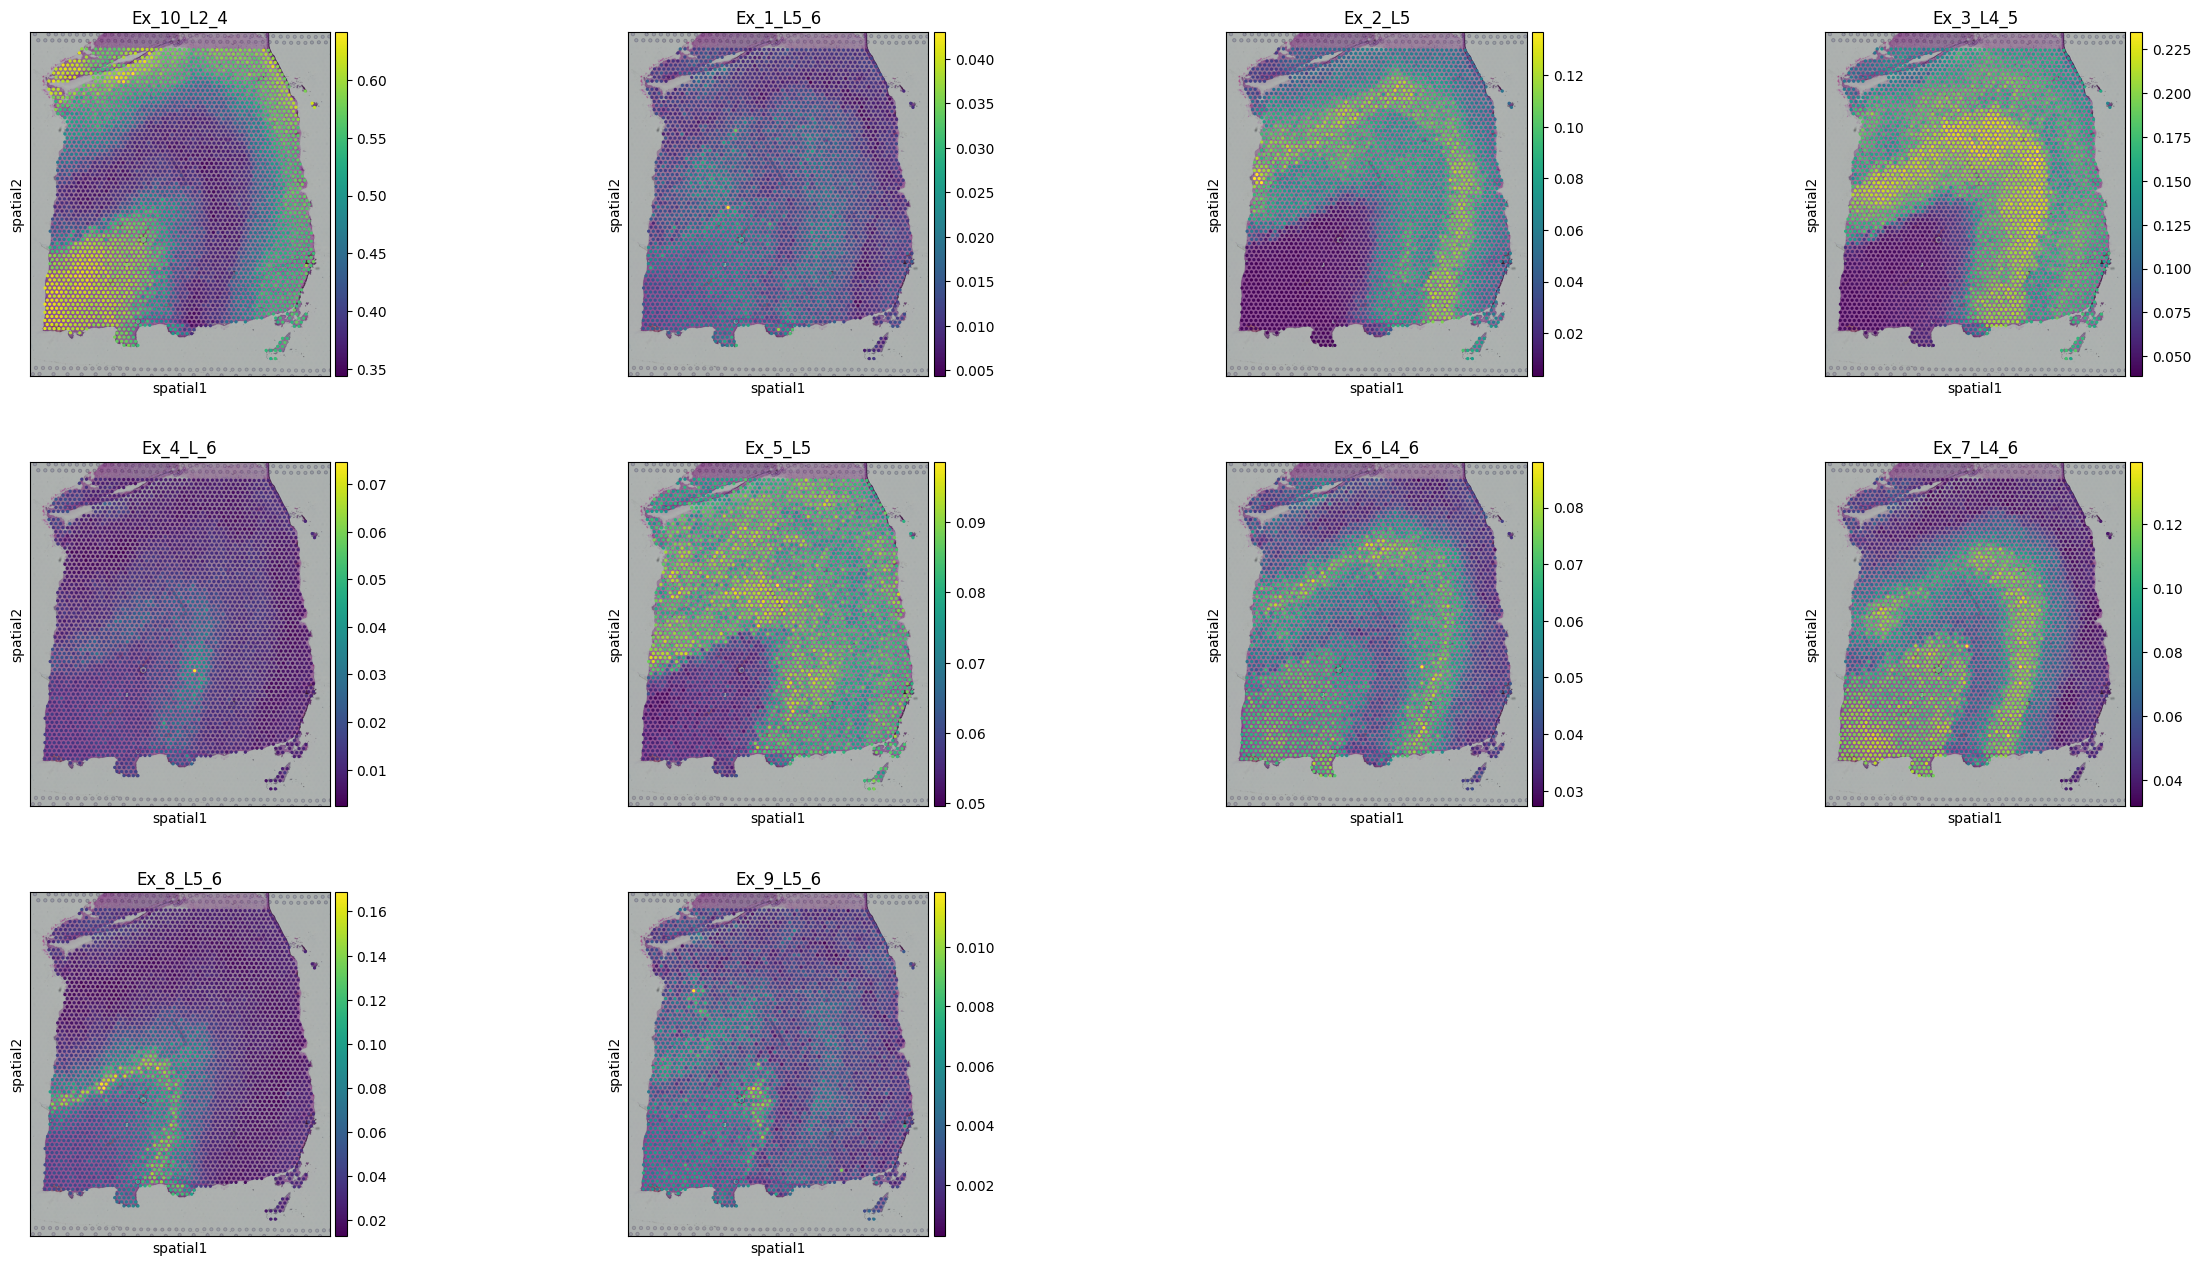

In [48]:
sc.pl.spatial(st_data,
              color=('Ex_10_L2_4', 'Ex_1_L5_6', 'Ex_2_L5', 'Ex_3_L4_5', 'Ex_4_L_6', 'Ex_5_L5', 'Ex_6_L4_6', 'Ex_7_L4_6', 'Ex_8_L5_6', 'Ex_9_L5_6'))

In [25]:
from sklearn.metrics import mean_squared_error,roc_auc_score,normalized_mutual_info_score,adjusted_rand_score
def metric_libd(predict):
    dictio ={}
    results = {}
    dictio['Ex_9_L5_6'] = ["Layer6","Layer5"]
    dictio['Ex_8_L5_6'] = ["Layer6","Layer5"]
    dictio['Ex_7_L4_6'] = ["Layer6","Layer4"]
    dictio['Ex_6_L4_6'] = ["Layer6","Layer4"]
    dictio['Ex_5_L5'] = ["Layer5"]
    dictio['Ex_4_L_6'] = ["Layer6"]
    dictio['Ex_3_L4_5'] = ["Layer4","Layer5"]
    dictio['Ex_2_L5']=["Layer5"]
    dictio['Ex_1_L5_6']=["Layer6","Layer5"]
    dictio['Ex_10_L2_4']=["Layer4","Layer2"]
    for i in dictio.keys():
        layers = dictio[i]
        binary_layer = [1 if j in layers else 0 for j in np.array(st_data.obs.layer)]
        ypred = predict.loc[:,i]
        auroc = roc_auc_score(binary_layer, ypred)
        results[i]=auroc
    return results

In [49]:
sp_prompt = metric_libd(cortex_predict)

In [50]:
sp_prompt

{'Ex_9_L5_6': 0.6637322366873818,
 'Ex_8_L5_6': 0.830693844414161,
 'Ex_7_L4_6': 0.5970737580484741,
 'Ex_6_L4_6': 0.5381567132025175,
 'Ex_5_L5': 0.7123181094504434,
 'Ex_4_L_6': 0.9585830892982186,
 'Ex_3_L4_5': 0.9314685754520786,
 'Ex_2_L5': 0.6756835016767544,
 'Ex_1_L5_6': 0.7681178540017592,
 'Ex_10_L2_4': 0.5274225803684403}

In [51]:
np.mean(list(sp_prompt.values()))

0.7203250262600228

## Spatial Clustering

In [17]:
clus_model = sp.SpatialCluster()

In [18]:
cortex_clus_annotations = clus_model.fit_predict(st_array = st_df,
                                                 x_cor = st_X,
                                                 y_cor = st_Y,n_cluster=7)
st_data.obs.loc[:,"SpatialPrompt: clusters"] = cortex_clus_annotations

Spatial clustering:  |████████████████████████████████████████| 5/5 [100%] in 1.9s (2.68/s) 
Executed in 1.8699700832366943 second


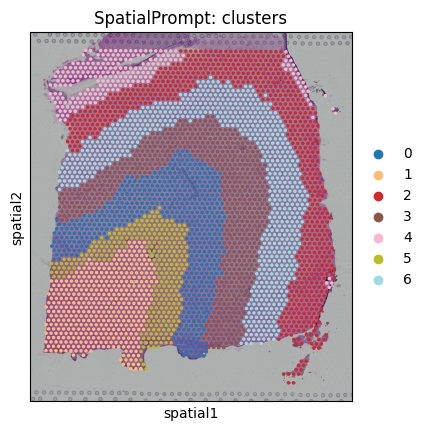

In [19]:
sc.pl.spatial(st_data,color=("SpatialPrompt: clusters"),
              palette="tab20")

In [20]:
valids = ~pd.isna(st_data.obs.layer)
print(normalized_mutual_info_score(cortex_clus_annotations[valids],st_data.obs.layer[valids]))

0.7081776384943014
